In [1]:
import os
import warnings
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import skew, kurtosis

file_path = r"C:\Users\simeo\OneDrive\Documents\UNC\Spring 2025\STOR 765\Inc_RNA_Protein_Predictions_Sample_Data\ENST00000429829.6_predictions.tsv"
df = pd.read_csv(file_path, sep='\t')
df.head()

,rna_index,rna_start,rna_end,dna_index,dna_start,dna_end,HNRNPC,HNRNPK,HNRNPM,MATR3,PTBP1,SRSF1,TIA1
0,50,0,100,73852673,73852623,73852723,0.694644,0.488768,0.301806,0.913165,0.393542,0.366644,0.848362
1,60,10,110,73852663,73852613,73852713,0.508488,0.226550,0.346506,0.859849,0.331914,0.433435,0.663155
2,70,20,120,73852653,73852603,73852703,0.069667,0.251957,0.108793,0.624135,0.230707,0.219274,0.116439
3,80,30,130,73852643,73852593,73852693,0.230525,0.683498,0.082749,0.750837,0.601004,0.257597,0.130026
4,90,40,140,73852633,73852583,73852683,0.374508,0.943981,0.108518,0.918591,0.951651,0.412851,0.491435


In [2]:
# Variables for percentiles, max-min, mean, variance, skew, and kurtosis
proteins = ['HNRNPC', 'HNRNPK', 'HNRNPM', 'MATR3', 'PTBP1', 'SRSF1', 'TIA1']
proportions, max_min, means, variances, skews, kurtoses = {}, {}, {}, {}, {}, {}

# Summary Statistic Feature Extraction
N = 20
for protein in proteins:
    df[f'{protein}_percentile'] = pd.cut(df[protein], bins=[i/N for i in range(N+1)], labels=False, include_lowest=True)
    for i in range(N):
        percentile_data = df[df[f'{protein}_percentile'] == i][protein] - (i / N)
        proportions[f'{protein}_percentile{i}'] = percentile_data.shape[0] / df.shape[0]
        max_min[f'{protein}_percentile{i}_max_min'] = percentile_data.max() - percentile_data.min()
        means[f'{protein}_percentile{i}_mean'] = percentile_data.mean()
        variances[f'{protein}_percentile{i}_variance'] = percentile_data.var()
        skews[f'{protein}_percentile{i}_skew'] = skew(percentile_data)
        kurtoses[f'{protein}_percentile{i}_kurtosis'] = kurtosis(percentile_data)

# Summary Statistics Dataframe
data = {'Protein': proteins}
for i in range(N):
    lower_bound = i / N
    upper_bound = (i + 1) / N
    data[f'Percentile_({lower_bound:.2f}-{upper_bound:.2f})_Proportion'] = [proportions[f'{protein}_percentile{i}'] for protein in proteins]
    data[f'Percentile_({lower_bound:.2f}-{upper_bound:.2f})_Max_Min'] = [max_min[f'{protein}_percentile{i}_max_min'] for protein in proteins]
    data[f'Percentile_({lower_bound:.2f}-{upper_bound:.2f})_Mean'] = [means[f'{protein}_percentile{i}_mean'] for protein in proteins]
    data[f'Percentile_({lower_bound:.2f}-{upper_bound:.2f})_Variance'] = [variances[f'{protein}_percentile{i}_variance'] for protein in proteins]
    data[f'Percentile_({lower_bound:.2f}-{upper_bound:.2f})_Skew'] = [skews[f'{protein}_percentile{i}_skew'] for protein in proteins]
    data[f'Percentile_({lower_bound:.2f}-{upper_bound:.2f})_Kurtosis'] = [kurtoses[f'{protein}_percentile{i}_kurtosis'] for protein in proteins]
result_df = pd.DataFrame(data).fillna(0)
result_df

,Protein,Percentile_(0.00-0.05)_Proportion,Percentile_(0.00-0.05)_Max_Min,Percentile_(0.00-0.05)_Mean,Percentile_(0.00-0.05)_Variance,Percentile_(0.00-0.05)_Skew,Percentile_(0.00-0.05)_Kurtosis,Percentile_(0.05-0.10)_Proportion,Percentile_(0.05-0.10)_Max_Min,Percentile_(0.05-0.10)_Mean,...,Percentile_(0.90-0.95)_Mean,Percentile_(0.90-0.95)_Variance,Percentile_(0.90-0.95)_Skew,Percentile_(0.90-0.95)_Kurtosis,Percentile_(0.95-1.00)_Proportion,Percentile_(0.95-1.00)_Max_Min,Percentile_(0.95-1.00)_Mean,Percentile_(0.95-1.00)_Variance,Percentile_(0.95-1.00)_Skew,Percentile_(0.95-1.00)_Kurtosis
0,HNRNPC,0.263185,0.047526,0.026481,0.000154,0.071730,-0.973721,0.140992,0.049580,0.022864,...,0.025920,0.000189,-0.267206,-1.142665,0.076240,0.046452,0.020732,0.000185,0.142634,-1.343603
1,HNRNPK,0.320627,0.049665,0.015337,0.000183,0.846699,-0.398091,0.096084,0.049718,0.022185,...,0.026942,0.000184,-0.046733,-1.171179,0.076240,0.047051,0.024987,0.000190,-0.205095,-1.256121
2,HNRNPM,0.350914,0.049788,0.015387,0.000196,0.820371,-0.465589,0.097650,0.049551,0.022147,...,0.031312,0.000164,-0.509934,-0.991651,0.071018,0.048842,0.025458,0.000201,-0.092142,-1.192633
3,MATR3,0.079373,0.049606,0.028374,0.000170,-0.215028,-0.919402,0.061619,0.049278,0.022187,...,0.024935,0.000216,0.203788,-1.238457,0.074674,0.045915,0.022066,0.000159,-0.010917,-0.968210
4,PTBP1,0.183290,0.049621,0.021213,0.000207,0.409171,-1.072641,0.098695,0.049861,0.022614,...,0.025035,0.000208,-0.085604,-0.990113,0.048564,0.048558,0.026150,0.000187,-0.127687,-1.206626
5,SRSF1,0.152480,0.048919,0.022927,0.000194,0.281039,-1.089064,0.107050,0.049510,0.022558,...,0.027437,0.000239,-0.254169,-1.133193,0.019843,0.037339,0.016795,0.000131,0.051548,-1.167818
6,TIA1,0.147258,0.049732,0.027786,0.000164,-0.038431,-1.097162,0.098172,0.049286,0.021362,...,0.028890,0.000189,-0.365204,-1.059640,0.048564,0.045429,0.021161,0.000164,0.351579,-1.097854


In [3]:
# Flatten the dataframe
flattened_data = {}

for protein in result_df['Protein']:
    protein_data = result_df[result_df['Protein'] == protein].drop(columns=['Protein']).to_dict(orient='records')[0]
    for column, value in protein_data.items():
        flattened_data[f'{protein}_{column}'] = value

# Create a new dataframe from the flattened data
flattened_summary_statistics_df = pd.DataFrame([flattened_data])
flattened_summary_statistics_df

,HNRNPC_Percentile_(0.00-0.05)_Proportion,HNRNPC_Percentile_(0.00-0.05)_Max_Min,HNRNPC_Percentile_(0.00-0.05)_Mean,HNRNPC_Percentile_(0.00-0.05)_Variance,HNRNPC_Percentile_(0.00-0.05)_Skew,HNRNPC_Percentile_(0.00-0.05)_Kurtosis,HNRNPC_Percentile_(0.05-0.10)_Proportion,HNRNPC_Percentile_(0.05-0.10)_Max_Min,HNRNPC_Percentile_(0.05-0.10)_Mean,HNRNPC_Percentile_(0.05-0.10)_Variance,...,TIA1_Percentile_(0.90-0.95)_Mean,TIA1_Percentile_(0.90-0.95)_Variance,TIA1_Percentile_(0.90-0.95)_Skew,TIA1_Percentile_(0.90-0.95)_Kurtosis,TIA1_Percentile_(0.95-1.00)_Proportion,TIA1_Percentile_(0.95-1.00)_Max_Min,TIA1_Percentile_(0.95-1.00)_Mean,TIA1_Percentile_(0.95-1.00)_Variance,TIA1_Percentile_(0.95-1.00)_Skew,TIA1_Percentile_(0.95-1.00)_Kurtosis
0,0.263185,0.047526,0.026481,0.000154,0.07173,-0.973721,0.140992,0.04958,0.022864,0.000193,...,0.02889,0.000189,-0.365204,-1.05964,0.048564,0.045429,0.021161,0.000164,0.351579,-1.097854


In [4]:
# Select top K waves
K = 10
protein_signals = {protein: df[protein].values for protein in proteins}
fft_features = {}

for protein, signal in protein_signals.items():
    # Perform Fourier Transform
    fft_values = np.fft.fft(signal)
    fft_freq = np.fft.fftfreq(len(signal), d=1/1000)
    fft_magnitude = np.abs(fft_values)
    
    # Extract top K waves
    top_k_indices = np.argsort(fft_magnitude)[-K:]
    fft_features[protein] = {
        'frequencies': fft_freq[top_k_indices],
        'magnitudes': fft_magnitude[top_k_indices]
    }

# Create a dataframe with the top K frequencies and magnitudes
top_k_df = pd.DataFrame()

for protein, features in fft_features.items():
    for i in range(K):
        top_k_df.loc[protein, f'Frequency_{i+1}'] = features['frequencies'][i]
        top_k_df.loc[protein, f'Magnitude_{i+1}'] = features['magnitudes'][i]

top_k_df

,Frequency_1,Magnitude_1,Frequency_2,Magnitude_2,Frequency_3,Magnitude_3,Frequency_4,Magnitude_4,Frequency_5,Magnitude_5,Frequency_6,Magnitude_6,Frequency_7,Magnitude_7,Frequency_8,Magnitude_8,Frequency_9,Magnitude_9,Frequency_10,Magnitude_10
HNRNPC,-69.973890,55.476141,9.921671,55.736050,-9.921671,55.736050,-91.383812,62.070426,91.383812,62.070426,1.044386,79.225402,-1.044386,79.225402,5.221932,92.328448,-5.221932,92.328448,0.0,657.341871
HNRNPK,20.887728,52.739730,-11.488251,52.953602,11.488251,52.953602,-3.133159,53.462903,3.133159,53.462903,-67.362924,54.376120,67.362924,54.376120,-0.522193,189.107320,0.522193,189.107320,0.0,659.393504
HNRNPM,-4.699739,57.083067,22.454308,61.781350,-22.454308,61.781350,1.566580,63.907757,-1.566580,63.907757,-2.610966,75.105925,2.610966,75.105925,-1.044386,98.231750,1.044386,98.231750,0.0,603.470567
MATR3,-35.509138,61.182627,-2.610966,62.593038,2.610966,62.593038,-1.044386,73.277051,1.044386,73.277051,1.566580,81.029901,-1.566580,81.029901,0.522193,85.401535,-0.522193,85.401535,0.0,997.412870
PTBP1,-35.509138,46.466199,5.221932,53.292384,-5.221932,53.292384,-1.566580,64.918581,1.566580,64.918581,2.610966,75.849934,-2.610966,75.849934,1.044386,117.437325,-1.044386,117.437325,0.0,707.239891
SRSF1,-4.177546,44.083147,89.817232,44.718518,-89.817232,44.718518,-2.610966,57.039804,2.610966,57.039804,1.566580,76.816592,-1.566580,76.816592,1.044386,81.547786,-1.044386,81.547786,0.0,662.072372
TIA1,22.454308,60.877593,35.509138,62.216170,-35.509138,62.216170,-6.266319,62.634710,6.266319,62.634710,5.221932,72.048096,-5.221932,72.048096,1.044386,72.273612,-1.044386,72.273612,0.0,788.111792


In [5]:
# Flatten the dataframe
flattened_data = {}

for protein in top_k_df.index:
    protein_data = top_k_df.loc[protein].to_dict()
    for column, value in protein_data.items():
        flattened_data[f'{protein}_{column}'] = value

# Create a new dataframe from the flattened data
flattened_fourier_transform_df = pd.DataFrame([flattened_data])
flattened_fourier_transform_df

,HNRNPC_Frequency_1,HNRNPC_Magnitude_1,HNRNPC_Frequency_2,HNRNPC_Magnitude_2,HNRNPC_Frequency_3,HNRNPC_Magnitude_3,HNRNPC_Frequency_4,HNRNPC_Magnitude_4,HNRNPC_Frequency_5,HNRNPC_Magnitude_5,...,TIA1_Frequency_6,TIA1_Magnitude_6,TIA1_Frequency_7,TIA1_Magnitude_7,TIA1_Frequency_8,TIA1_Magnitude_8,TIA1_Frequency_9,TIA1_Magnitude_9,TIA1_Frequency_10,TIA1_Magnitude_10
0,-69.97389,55.476141,9.921671,55.73605,-9.921671,55.73605,-91.383812,62.070426,91.383812,62.070426,...,5.221932,72.048096,-5.221932,72.048096,1.044386,72.273612,-1.044386,72.273612,0.0,788.111792


In [6]:
# Auto-correlation Matrices per Lag
lags = [0, 1, 2, 3]
autocorrelation_features_list = []
column_names = [f'{p1}_x_{p2}' for p1 in proteins for p2 in proteins if p1 <= p2]

for L in lags:
    autocorrelation_matrix = pd.DataFrame(index=proteins, columns=proteins)
    for protein1 in proteins:
        for protein2 in proteins:
            autocorrelation_matrix.loc[protein1, protein2] = df[protein1].corr(df[protein2].shift(L))
    autocorrelation_features_list.append(autocorrelation_matrix.where(np.triu(np.ones(autocorrelation_matrix.shape), k=0).astype(bool)).stack().values)

# Extract unique autocorrelations and transform to 1D arrays
autocorrelation_df = pd.DataFrame(autocorrelation_features_list, columns=column_names)
autocorrelation_df.index = [f'Autocorrelation({L})' for L in lags]
autocorrelation_df

,HNRNPC_x_HNRNPC,HNRNPC_x_HNRNPK,HNRNPC_x_HNRNPM,HNRNPC_x_MATR3,HNRNPC_x_PTBP1,HNRNPC_x_SRSF1,HNRNPC_x_TIA1,HNRNPK_x_HNRNPK,HNRNPK_x_HNRNPM,HNRNPK_x_MATR3,...,MATR3_x_MATR3,MATR3_x_PTBP1,MATR3_x_SRSF1,MATR3_x_TIA1,PTBP1_x_PTBP1,PTBP1_x_SRSF1,PTBP1_x_TIA1,SRSF1_x_SRSF1,SRSF1_x_TIA1,TIA1_x_TIA1
Autocorrelation(0),1.000000,0.343487,0.527737,0.595220,0.552068,0.493478,0.742052,1.000000,0.386044,0.535738,...,1.000000,0.763586,0.540355,0.702491,1.000000,0.587409,0.676603,1.000000,0.561258,1.000000
Autocorrelation(1),0.756032,0.271052,0.416690,0.515106,0.482880,0.326616,0.564011,0.822605,0.310767,0.500754,...,0.788572,0.639187,0.346942,0.512498,0.769100,0.370314,0.460689,0.736090,0.436737,0.731443
Autocorrelation(2),0.461247,0.128786,0.219421,0.338186,0.279816,0.091745,0.307091,0.580827,0.164776,0.363139,...,0.532194,0.405879,0.125059,0.267414,0.486674,0.137298,0.238103,0.397415,0.191807,0.374943
Autocorrelation(3),0.235977,0.005201,0.060244,0.138627,0.065033,-0.087643,0.109666,0.383374,0.067591,0.208966,...,0.297649,0.193109,-0.031937,0.096208,0.278683,-0.015821,0.114057,0.162188,0.013059,0.123167


In [7]:
# Flatten the dataframe
flattened_data = {}

for lag in autocorrelation_df.index:
    lag_data = autocorrelation_df.loc[lag].to_dict()
    for column, value in lag_data.items():
        if lag != 'Autocorrelation(0)' or column.split('_x_')[0] != column.split('_x_')[1]:
            flattened_data[f'{column}_{lag}'] = value

# Create a new dataframe from the flattened data
flattened_autocorrelation_df = pd.DataFrame([flattened_data])
flattened_autocorrelation_df

,HNRNPC_x_HNRNPK_Autocorrelation(0),HNRNPC_x_HNRNPM_Autocorrelation(0),HNRNPC_x_MATR3_Autocorrelation(0),HNRNPC_x_PTBP1_Autocorrelation(0),HNRNPC_x_SRSF1_Autocorrelation(0),HNRNPC_x_TIA1_Autocorrelation(0),HNRNPK_x_HNRNPM_Autocorrelation(0),HNRNPK_x_MATR3_Autocorrelation(0),HNRNPK_x_PTBP1_Autocorrelation(0),HNRNPK_x_SRSF1_Autocorrelation(0),...,MATR3_x_MATR3_Autocorrelation(3),MATR3_x_PTBP1_Autocorrelation(3),MATR3_x_SRSF1_Autocorrelation(3),MATR3_x_TIA1_Autocorrelation(3),PTBP1_x_PTBP1_Autocorrelation(3),PTBP1_x_SRSF1_Autocorrelation(3),PTBP1_x_TIA1_Autocorrelation(3),SRSF1_x_SRSF1_Autocorrelation(3),SRSF1_x_TIA1_Autocorrelation(3),TIA1_x_TIA1_Autocorrelation(3)
0,0.343487,0.527737,0.59522,0.552068,0.493478,0.742052,0.386044,0.535738,0.526527,0.363587,...,0.297649,0.193109,-0.031937,0.096208,0.278683,-0.015821,0.114057,0.162188,0.013059,0.123167


In [8]:
# Combine all flattened dataframes into one
combined_flattened_df = pd.concat([flattened_summary_statistics_df, flattened_fourier_transform_df, flattened_autocorrelation_df], axis=1)
combined_flattened_df

,HNRNPC_Percentile_(0.00-0.05)_Proportion,HNRNPC_Percentile_(0.00-0.05)_Max_Min,HNRNPC_Percentile_(0.00-0.05)_Mean,HNRNPC_Percentile_(0.00-0.05)_Variance,HNRNPC_Percentile_(0.00-0.05)_Skew,HNRNPC_Percentile_(0.00-0.05)_Kurtosis,HNRNPC_Percentile_(0.05-0.10)_Proportion,HNRNPC_Percentile_(0.05-0.10)_Max_Min,HNRNPC_Percentile_(0.05-0.10)_Mean,HNRNPC_Percentile_(0.05-0.10)_Variance,...,MATR3_x_MATR3_Autocorrelation(3),MATR3_x_PTBP1_Autocorrelation(3),MATR3_x_SRSF1_Autocorrelation(3),MATR3_x_TIA1_Autocorrelation(3),PTBP1_x_PTBP1_Autocorrelation(3),PTBP1_x_SRSF1_Autocorrelation(3),PTBP1_x_TIA1_Autocorrelation(3),SRSF1_x_SRSF1_Autocorrelation(3),SRSF1_x_TIA1_Autocorrelation(3),TIA1_x_TIA1_Autocorrelation(3)
0,0.263185,0.047526,0.026481,0.000154,0.07173,-0.973721,0.140992,0.04958,0.022864,0.000193,...,0.297649,0.193109,-0.031937,0.096208,0.278683,-0.015821,0.114057,0.162188,0.013059,0.123167


In [9]:
# Directory containing the files
directory_path = r"C:\Users\simeo\OneDrive\Documents\UNC\Spring 2025\STOR 765\Inc_RNA_Protein_Predictions_Sample_Data"

# List to store the combined flattened dataframes
combined_flattened_dfs = []

# Loop through each file in the directory
for filename in os.listdir(directory_path):
    if filename.endswith(".tsv"):
        file_path = os.path.join(directory_path, filename)
        
        # Read the file
        df = pd.read_csv(file_path, sep='\t')
        
        # Perform the operations as in the previous cells
        # Summary Statistic Feature Extraction
        proteins = ['HNRNPC', 'HNRNPK', 'HNRNPM', 'MATR3', 'PTBP1', 'SRSF1', 'TIA1']
        proportions, max_min, means, variances, skews, kurtoses = {}, {}, {}, {}, {}, {}
        N = 20
        for protein in proteins:
            df[f'{protein}_percentile'] = pd.cut(df[protein], bins=[i/N for i in range(N+1)], labels=False, include_lowest=True)
            for i in range(N):
                percentile_data = df[df[f'{protein}_percentile'] == i][protein] - (i / N)
                proportions[f'{protein}_percentile{i}'] = percentile_data.shape[0] / df.shape[0]
                max_min[f'{protein}_percentile{i}_max_min'] = percentile_data.max() - percentile_data.min()
                means[f'{protein}_percentile{i}_mean'] = percentile_data.mean()
                variances[f'{protein}_percentile{i}_variance'] = percentile_data.var()
                skews[f'{protein}_percentile{i}_skew'] = skew(percentile_data)
                kurtoses[f'{protein}_percentile{i}_kurtosis'] = kurtosis(percentile_data)
        
        # Summary Statistics Dataframe
        data = {'Protein': proteins}
        for i in range(N):
            lower_bound = i / N
            upper_bound = (i + 1) / N
            data[f'Percentile_({lower_bound:.2f}-{upper_bound:.2f})_Proportion'] = [proportions[f'{protein}_percentile{i}'] for protein in proteins]
            data[f'Percentile_({lower_bound:.2f}-{upper_bound:.2f})_Max_Min'] = [max_min[f'{protein}_percentile{i}_max_min'] for protein in proteins]
            data[f'Percentile_({lower_bound:.2f}-{upper_bound:.2f})_Mean'] = [means[f'{protein}_percentile{i}_mean'] for protein in proteins]
            data[f'Percentile_({lower_bound:.2f}-{upper_bound:.2f})_Variance'] = [variances[f'{protein}_percentile{i}_variance'] for protein in proteins]
            data[f'Percentile_({lower_bound:.2f}-{upper_bound:.2f})_Skew'] = [skews[f'{protein}_percentile{i}_skew'] for protein in proteins]
            data[f'Percentile_({lower_bound:.2f}-{upper_bound:.2f})_Kurtosis'] = [kurtoses[f'{protein}_percentile{i}_kurtosis'] for protein in proteins]
        result_df = pd.DataFrame(data).fillna(0)
        
        # Flatten the dataframe
        flattened_data = {}
        for protein in result_df['Protein']:
            protein_data = result_df[result_df['Protein'] == protein].drop(columns=['Protein']).to_dict(orient='records')[0]
            for column, value in protein_data.items():
                flattened_data[f'{protein}_{column}'] = value
        flattened_summary_statistics_df = pd.DataFrame([flattened_data])
        
        # Select top K waves
        K = 10
        protein_signals = {protein: df[protein].values for protein in proteins}
        fft_features = {}
        for protein, signal in protein_signals.items():
            fft_values = np.fft.fft(signal)
            fft_freq = np.fft.fftfreq(len(signal), d=1/1000)
            fft_magnitude = np.abs(fft_values)
            top_k_indices = np.argsort(fft_magnitude)[-K:]
            fft_features[protein] = {
                'frequencies': fft_freq[top_k_indices],
                'magnitudes': fft_magnitude[top_k_indices]
            }
        top_k_df = pd.DataFrame()
        for protein, features in fft_features.items():
            for i in range(K):
                top_k_df.loc[protein, f'Frequency_{i+1}'] = features['frequencies'][i]
                top_k_df.loc[protein, f'Magnitude_{i+1}'] = features['magnitudes'][i]
        
        # Flatten the dataframe
        flattened_data = {}
        for protein in top_k_df.index:
            protein_data = top_k_df.loc[protein].to_dict()
            for column, value in protein_data.items():
                flattened_data[f'{protein}_{column}'] = value
        flattened_fourier_transform_df = pd.DataFrame([flattened_data])
        
        # Auto-correlation Matrices per Lag
        lags = [0, 1, 2, 3]
        autocorrelation_features_list = []
        column_names = [f'{p1}_x_{p2}' for p1 in proteins for p2 in proteins if p1 <= p2]
        for L in lags:
            autocorrelation_matrix = pd.DataFrame(index=proteins, columns=proteins)
            for protein1 in proteins:
                for protein2 in proteins:
                    autocorrelation_matrix.loc[protein1, protein2] = df[protein1].corr(df[protein2].shift(L))
            autocorrelation_features_list.append(autocorrelation_matrix.where(np.triu(np.ones(autocorrelation_matrix.shape), k=0).astype(bool)).stack().values)
        autocorrelation_df = pd.DataFrame(autocorrelation_features_list, columns=column_names)
        autocorrelation_df.index = [f'Autocorrelation({L})' for L in lags]
        
        # Flatten the dataframe
        flattened_data = {}
        for lag in autocorrelation_df.index:
            lag_data = autocorrelation_df.loc[lag].to_dict()
            for column, value in lag_data.items():
                if lag != 'Autocorrelation(0)' or column.split('_x_')[0] != column.split('_x_')[1]:
                    flattened_data[f'{column}_{lag}'] = value
        flattened_autocorrelation_df = pd.DataFrame([flattened_data])
        
        # Combine all flattened dataframes into one
        combined_flattened_df = pd.concat([flattened_summary_statistics_df, flattened_fourier_transform_df, flattened_autocorrelation_df], axis=1)
        
        # Append the combined flattened dataframe to the list
        combined_flattened_dfs.append(combined_flattened_df)

# Create a new dataframe with all the combined flattened dataframes as rows
final_combined_df = pd.concat(combined_flattened_dfs, ignore_index=True)
# Set the row names to be the lncRNA names
final_combined_df.index = [filename.replace("_predictions.tsv", "") for filename in os.listdir(directory_path) if filename.endswith(".tsv")]

# Final combined dataframe
warnings.filterwarnings("ignore")
final_combined_df

C:\Users\simeo\AppData\Local\Temp\ipykernel_16084\4164034881.py:28: SmallSampleWarning: One or more sample arguments is too small; all returned values will be NaN. See documentation for sample size requirements.
  skews[f'{protein}_percentile{i}_skew'] = skew(percentile_data)
C:\Users\simeo\AppData\Local\Temp\ipykernel_16084\4164034881.py:29: SmallSampleWarning: One or more sample arguments is too small; all returned values will be NaN. See documentation for sample size requirements.
  kurtoses[f'{protein}_percentile{i}_kurtosis'] = kurtosis(percentile_data)
C:\Users\simeo\AppData\Local\Temp\ipykernel_16084\4164034881.py:28: SmallSampleWarning: One or more sample arguments is too small; all returned values will be NaN. See documentation for sample size requirements.
  skews[f'{protein}_percentile{i}_skew'] = skew(percentile_data)
C:\Users\simeo\AppData\Local\Temp\ipykernel_16084\4164034881.py:29: SmallSampleWarning: One or more sample arguments is too small; all returned values will be

,HNRNPC_Percentile_(0.00-0.05)_Proportion,HNRNPC_Percentile_(0.00-0.05)_Max_Min,HNRNPC_Percentile_(0.00-0.05)_Mean,HNRNPC_Percentile_(0.00-0.05)_Variance,HNRNPC_Percentile_(0.00-0.05)_Skew,HNRNPC_Percentile_(0.00-0.05)_Kurtosis,HNRNPC_Percentile_(0.05-0.10)_Proportion,HNRNPC_Percentile_(0.05-0.10)_Max_Min,HNRNPC_Percentile_(0.05-0.10)_Mean,HNRNPC_Percentile_(0.05-0.10)_Variance,...,MATR3_x_MATR3_Autocorrelation(3),MATR3_x_PTBP1_Autocorrelation(3),MATR3_x_SRSF1_Autocorrelation(3),MATR3_x_TIA1_Autocorrelation(3),PTBP1_x_PTBP1_Autocorrelation(3),PTBP1_x_SRSF1_Autocorrelation(3),PTBP1_x_TIA1_Autocorrelation(3),SRSF1_x_SRSF1_Autocorrelation(3),SRSF1_x_TIA1_Autocorrelation(3),TIA1_x_TIA1_Autocorrelation(3)
ENST00000429829.6,0.263185,0.047526,0.026481,0.000154,0.071730,-0.973721,0.140992,0.049580,0.022864,0.000193,...,0.297649,0.193109,-0.031937,0.096208,0.278683,-0.015821,0.114057,0.162188,0.013059,0.123167
ENST00000431460.2,0.342105,0.042103,0.020874,0.000199,0.243675,-1.180162,0.078947,0.032469,0.017052,0.000344,...,0.237364,-0.115422,-0.049577,-0.143359,-0.137778,-0.059885,-0.117260,-0.084405,-0.121961,0.037662
ENST00000501122.3,0.180406,0.048587,0.025122,0.000173,0.126523,-1.085207,0.108761,0.049237,0.023245,0.000212,...,0.406652,0.166878,-0.055979,0.097474,0.269207,0.091790,0.088177,0.263036,0.034969,0.086222
ENST00000521028.4,0.421538,0.049861,0.023592,0.000204,0.225078,-1.154446,0.147692,0.047392,0.017712,0.000178,...,0.292615,0.119764,-0.101466,0.034540,0.058003,-0.165279,-0.054070,0.128520,-0.071790,0.016546
ENST00000534336.4,0.270974,0.047478,0.021167,0.000151,0.627532,-0.660524,0.116683,0.049682,0.023546,0.000223,...,0.263634,0.122931,0.054018,0.142361,0.247048,0.130133,0.122510,0.269469,0.159725,0.215392
ENST00000597346.1,0.425576,0.049176,0.024280,0.000166,0.247441,-1.045428,0.177569,0.049975,0.021062,0.000194,...,0.361456,0.023045,-0.008480,-0.087525,0.306713,0.162439,0.241138,0.368780,0.146927,0.319551
ENST00000601203.1,0.567757,0.048809,0.022179,0.000149,0.471997,-0.689185,0.130841,0.046713,0.024500,0.000230,...,0.419770,0.268306,0.009644,0.106231,0.422955,0.105995,0.219046,0.323967,0.074237,0.128965
ENST00000648200.2,0.356670,0.049234,0.021004,0.000152,0.518953,-0.752601,0.116840,0.049455,0.020075,0.000202,...,0.288796,0.249247,-0.054073,0.092383,0.423786,0.093194,0.169959,0.266762,0.096028,0.234341
ENST00000707047.1,0.515924,0.048183,0.018439,0.000138,0.908527,-0.179075,0.152866,0.049270,0.021850,0.000209,...,0.368881,0.251401,0.131199,0.108577,0.235472,0.062285,-0.126981,0.340800,0.027656,0.277215
ENST00000710492.1,0.516393,0.046262,0.015942,0.000175,0.974486,-0.256716,0.098361,0.045827,0.024689,0.000220,...,0.214327,0.115132,-0.299396,0.013108,0.388976,0.047337,0.260835,0.139120,0.035375,0.352879


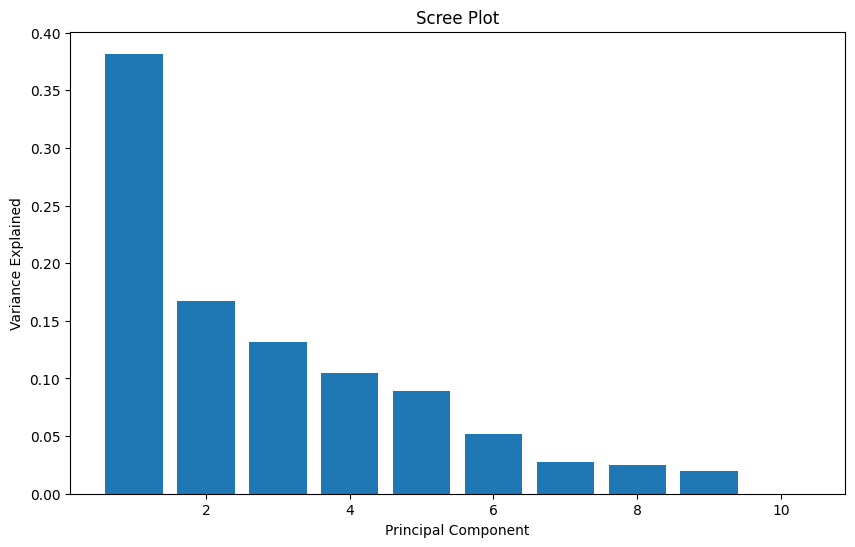

In [10]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

# Standardize the data
scaler = StandardScaler()
standardized_data = scaler.fit_transform(final_combined_df)

# Perform PCA
pca = PCA()
pca.fit(standardized_data)

# Plot the scree plot
plt.figure(figsize=(10, 6))
plt.bar(range(1, len(pca.explained_variance_ratio_) + 1), pca.explained_variance_ratio_)
plt.title('Scree Plot')
plt.xlabel('Principal Component')
plt.ylabel('Variance Explained')
plt.show()

In [11]:
# Transform the data using the PCA model
pca_transformed_data = pca.transform(standardized_data)

# Select the first 10 principal components
first_10_pcs = pca_transformed_data[:, :10]

# Create a DataFrame with the first 10 principal components and keep the row names from flattened_df
first_10_pcs_df = pd.DataFrame(first_10_pcs, columns=[f'PC{i+1}' for i in range(10)], index=final_combined_df.index)
first_10_pcs_df

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10
ENST00000429829.6,8.651269,-6.055905,5.327615,-0.402350,2.083018,5.906772,-8.913825,-1.710410,10.267976,1.763768e-15
ENST00000431460.2,-58.985718,-9.143913,2.565433,1.061756,-0.458715,-0.909170,-0.009537,0.469242,-0.055911,-4.868628e-15
ENST00000501122.3,9.853988,-7.038188,8.247010,2.305356,2.360708,5.579131,-8.096962,-2.472367,-10.218558,-4.655509e-15
ENST00000521028.4,4.531529,1.429336,-2.980999,-26.738605,13.594184,-5.566603,1.499571,0.016923,-0.602489,2.539064e-15
ENST00000534336.4,7.452729,-5.775547,3.720042,2.336036,1.232615,11.528932,11.568395,-6.688822,0.648176,4.286415e-15
ENST00000597346.1,14.284749,-9.979610,11.174132,9.877386,-2.561165,-17.823726,2.261450,-2.849760,0.827006,-1.978493e-15
ENST00000601203.1,5.263782,0.978796,-12.462105,-9.843159,-25.854325,-0.164410,-0.631329,-0.372419,-0.580335,-1.301707e-14
ENST00000648200.2,11.243800,-6.251187,3.717631,3.916599,0.627439,3.415599,3.294028,14.396920,-0.100165,3.350188e-15
ENST00000707047.1,2.520089,3.835054,-29.860527,13.364924,9.504013,-1.745465,-1.004537,-0.872012,-0.281189,3.359120e-14
ENST00000710492.1,-4.816217,38.001164,10.551768,4.122057,-0.527770,-0.221060,0.032745,0.082706,0.095489,-1.800714e-14


In [33]:
from sklearn.manifold import TSNE
import plotly.express as px

# Perform t-SNE with a lower perplexity
tsne = TSNE(n_components=3, random_state=42, perplexity=9)
tsne_transformed_data = tsne.fit_transform(standardized_data)

# Create a DataFrame with the t-SNE results
tsne_df = pd.DataFrame(tsne_transformed_data, columns=['TSNE1', 'TSNE2', 'TSNE3'], index=final_combined_df.index)

# Create a 3-D scatter plot with Plotly
fig = px.scatter_3d(tsne_df, x='TSNE1', y='TSNE2', z='TSNE3', color=tsne_df.index, title='t-SNE Clustering Results')

# Update layout for better visualization
fig.update_layout(
    scene=dict(
        xaxis_title='TSNE1',
        yaxis_title='TSNE2',
        zaxis_title='TSNE3'
    ),
    legend_title_text='lncRNAs',
    width=1000,  # Set the width of the plot
    height=800   # Set the height of the plot
)

# Show the plot
fig.show()